In [1]:
### GROUP 2 ###

# B.J.T. Donkers - 1506897
# S. van der Leek - 1564226
# L. Sloot - 1365711
# S. Diemel  - 1645749
# A.E. Murariu - 1532081
# Z.V. Petrov - 1554999

In [2]:
# imports
import pandas as pd
import pm4py

In [3]:
# read the data (2012)
df_total = pm4py.convert_to_dataframe(pm4py.read_xes("data/BPI_Challenge_2012.xes"))

# read the data (road traffic fines)
# df = pd.read_csv('data/Road_Traffic_Fine_Management_Process-training.csv')

# read the data (2017)
# df = pd.read_csv('data/BPI Challenge 2017-training.csv')

# read the data (2018)
# df = pd.read_csv('data/BPI Challenge 2018-training.csv')

df_total.head(10)

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
5,10862,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
6,10862,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
7,10862,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
8,10862,COMPLETE,O_CREATED,2011-10-01 11:45:11.197000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
9,10862,COMPLETE,O_SENT,2011-10-01 11:45:11.380000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000


In [4]:
# Percentage cut-off points for training, validation and testing datasets
training_percentage = 0.70 
validation_percentage = 0.80

# Defining database-specific variables
case_column = "case:concept:name"
registration_time_column = "case:REG_DATE"
event_column = "concept:name"
timestamp_column = "time:timestamp"
amount_column = 'case:AMOUNT_REQ'
row_nr_column = 'row_nr'
index_column = "index"
#timeformat_registration = "%Y-%m-%dT%H:%M:%S" # new time format
timeformat_timestamp = "%Y-%m-%d %H:%M:%S.%f"
lifecycle_column = 'lifecycle:transition' # additional info for the timePrediction_onTheFly, set to None if you don't want to use it
amount_column_in_data = True

# Names of new columns we will add in the notebooks
position_column = "Position" # added in this tool notebook
baseline_la_next_event_column = "Baseline Last Event Prediction for Next Activity" # added in the baseline notebook
baseline_la_next_timestamp_column = "Baseline Last Event Prediction for Next Timestamp" # added in the baseline notebook
baseline_pos_next_event_column = "Baseline Last Pos Prediction for Next Activity" # added in the baseline notebook
baseline_pos_next_timestamp_column = "Baseline Last Pos Prediction for Next Timestamp" # added in the baseline notebook
pred_event_otf_column = "OTF Prediction for Next Activity" # added by event_onthefly notebook
otf_next_timestamp_column = "OnTheFly Prediction for Next Timestamp" # added by the timePrediction_onTheFly notebook


In [5]:
# Basic data preprocessing of the timestamps and reg dates
df_total[timestamp_column] = [pd.Timestamp(time).astimezone(None) for time in df_total[timestamp_column]]
df_total[registration_time_column]= [pd.Timestamp(reg_time).astimezone(None) for reg_time in df_total[registration_time_column]]

# Turning the case and amount values back into numbers instead of strings
df_total[case_column] = [int(case) for case in df_total[case_column]]
if (amount_column_in_data):
    df_total[amount_column] = [int(amount) for amount in df_total[amount_column]]

df_total.iloc[0][timestamp_column]

Timestamp('2011-09-30 22:38:44.546000')

In [6]:
df_total = df_total.sort_values(by=[timestamp_column]).reset_index()
# We fill in the Position column that shows which position is a certain event in the trace (the first event is 1)
df_total[position_column] = df_total.groupby([case_column]).cumcount()+1

#df_total.head(10)

In [7]:
# We calculate the timestamps where the data will be split on
training_cutoff_timestamp = df_total.iloc[[int(training_percentage*len(df_total))]].iloc[0][timestamp_column]
validation_cutoff_timestamp = df_total.iloc[[int(validation_percentage*len(df_total))]].iloc[0][timestamp_column]

(training_cutoff_timestamp, validation_cutoff_timestamp)

(Timestamp('2012-01-26 10:14:40.465000'),
 Timestamp('2012-02-09 14:41:26.559000'))

In [8]:
# dictionary to store whether each case has an event that occured before and or after the cutoff timestamps

dict_overlapping_cases = {}

def find_overlapping_cases(case, timestamp):
    templist = [timestamp < training_cutoff_timestamp, timestamp > training_cutoff_timestamp, timestamp < validation_cutoff_timestamp, timestamp > validation_cutoff_timestamp]
    if (case in dict_overlapping_cases):
        dict_overlapping_cases[case] = [(a or b) for a,b in zip(templist, dict_overlapping_cases[case])]
    else:
        dict_overlapping_cases[case] = templist

[find_overlapping_cases(case,time) for case,time in zip(df_total[case_column],df_total[timestamp_column])]

def case_overlaps_a_timestamp(case):
    return (dict_overlapping_cases[case][0] and dict_overlapping_cases[case][1]) or (dict_overlapping_cases[case][2] and dict_overlapping_cases[case][3])

list_overlapping_cases = [case for case in dict_overlapping_cases.keys() if case_overlaps_a_timestamp(case)]
len(list_overlapping_cases)

1378

In [9]:
# splitting the data and removing all events belonging to cases that overlap the cutoff timestamps

df = df_total.iloc[:int(training_percentage*len(df_total))]
df_validation = df_total.iloc[int(training_percentage*len(df_total)):int(validation_percentage*len(df_total))]
df_test = df_total.iloc[int(validation_percentage*len(df_total)):]

df = df[[(case not in list_overlapping_cases) for case in df[case_column]]]
df_validation = df_validation[[(case not in list_overlapping_cases) for case in df_validation[case_column]]]
df_test = df_test[[(case not in list_overlapping_cases) for case in df_test[case_column]]]

# without removing overlapping events: (len(df_total),len(df),len(df_validation),len(df_test)) = (262200, 183540, 26220, 52440)
# with removing overlapping events: (len(df_total),len(df),len(df_validation),len(df_test)) = (262200, 161548, 5198, 37781)
(len(df_total),len(df),len(df_validation),len(df_test)) 

(262200, 161548, 5198, 37781)

In [10]:
# Running the notebook that adds the baseline predictions to df and df_test
%run -i "Baseline Prediction Tool.ipynb"

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', '_i2', 'pd', 'pm4py', '_i3', 'df_total', '_3', '_i4', 'training_percentage', 'validation_percentage', 'case_column', 'registration_time_column', 'event_column', 'timestamp_column', 'amount_column', 'row_nr_column', 'index_column', 'timeformat_timestamp', 'lifecycle_column', 'amount_column_in_data', 'position_column', 'baseline_la_next_event_column', 'baseline_la_next_timestamp_column', 'baseline_pos_next_event_column', 'baseline_pos_next_timestamp_column', 'pred_event_otf_column', 'otf_next_timestamp_column', '_i5', '_5', '_i6', '_i7', 'training_cutoff_timestamp', 'validation_cutoff_timestamp', '_7', '_i8', 'dict_overlapping_cases', 'find_overlapping_cases', 'case_overlaps_a_timestamp', 'list_overlapping_cases', '_8', '_i9', 'df', 'df_validation', 'df_test', '_9', '_i10', 

C:\Users\20203666\AppData\Local\Temp/ipykernel_11760/422821704.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[row_nr_column] = dataset.index
C:\Users\20203666\AppData\Local\Temp/ipykernel_11760/422821704.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_val[row_nr_column] = dataset_val.index
C:\Users\20203666\AppData\Local\Temp/ipykernel_11760/422821704.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

   case:concept:name            concept:name lifecycle:transition  \
0             173688             A_SUBMITTED             COMPLETE   
1             173688       A_PARTLYSUBMITTED             COMPLETE   
2             173688           A_PREACCEPTED             COMPLETE   
3             173688  W_Completeren aanvraag             SCHEDULE   
4             173691             A_SUBMITTED             COMPLETE   

           time:timestamp  case:AMOUNT_REQ  row_nr  
0 2011-09-30 22:38:44.546            20000       0  
1 2011-09-30 22:38:44.880            20000       1  
2 2011-09-30 22:39:37.906            20000       2  
3 2011-09-30 22:39:38.875            20000       3  
4 2011-10-01 06:08:58.256                0       4  
dict: Elapsed time during the whole program in seconds: 83.0625
train accuracy:0.8080390486798139
length df = 161548, length predictions = 161548
test accuracy:0.7386313465783665
test accuracy:0.12847682119205298
test accuracy:0.8156654888103652
length df = 37781, le

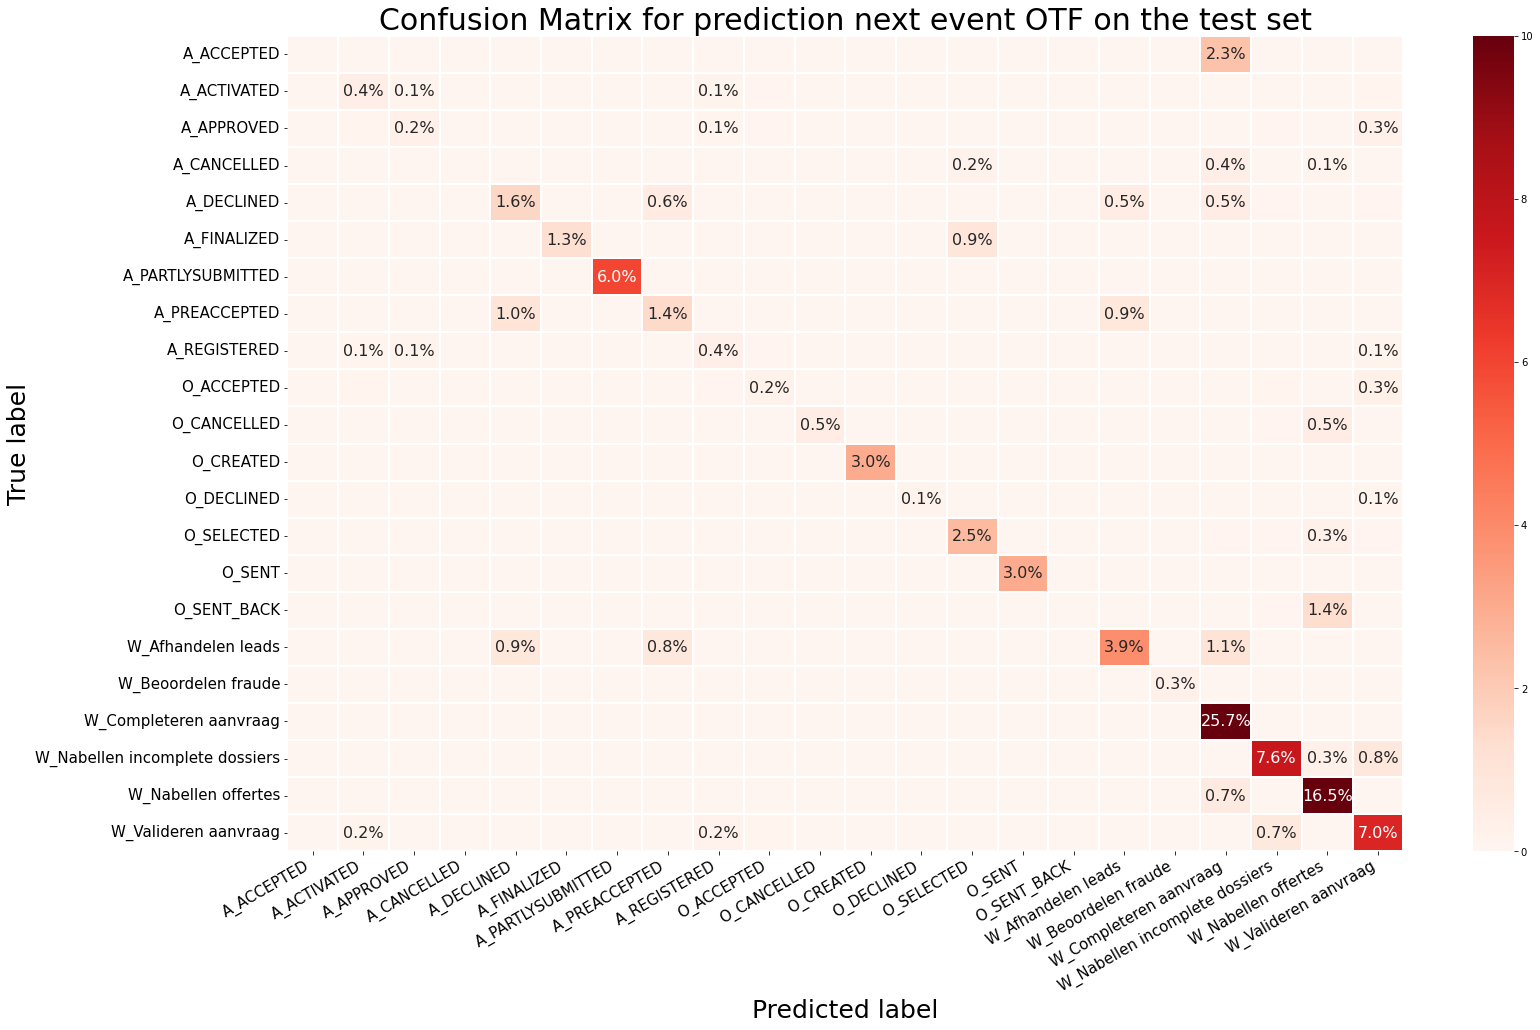

In [15]:
# Running the notebook that adds the on-the-fly event prediction to df and df_test
%run -i "event_otf.ipynb"

In [16]:
print(f'train accuracy event on the fly: {train_acc_event_otf*100}') # does still run because is in event_onthefly.ipynb
print(f'test accuracy event on the fly: {test_acc_event_otf*100}')

train accuracy event on the fly: 80.80390486798139
test accuracy event on the fly: 81.56654888103651


In [13]:
# Running the notebook that adds the on-the-fly event prediction to df and df_test
%run -i "timePrediction_onTheFly.ipynb" # Takes around 2 minutes to run

All columns are available in the dataframe
   case:concept:name            concept:name          time:timestamp  \
0             173688             A_SUBMITTED 2011-09-30 22:38:44.546   
1             173688       A_PARTLYSUBMITTED 2011-09-30 22:38:44.880   
2             173688           A_PREACCEPTED 2011-09-30 22:39:37.906   
3             173688  W_Completeren aanvraag 2011-09-30 22:39:38.875   
4             173688  W_Completeren aanvraag 2011-10-01 09:36:46.437   

  lifecycle:transition  row_nr  
0             COMPLETE       0  
1             COMPLETE       1  
2             COMPLETE       2  
3             SCHEDULE       3  
4                START       4  


timePrediction_onTheFly.ipynb:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",
timePrediction_onTheFly.ipynb:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    # df is the test set, this is used to train the model\n",
timePrediction_onTheFly.ipynb:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

dict: Elapsed time during the training the model in seconds: 246.984375
dict: Elapsed time during the setting of the parameters on the validation set took  3.328125 seconds.
The new learning rate is  0.1
dict: Elapsed time during the whole program on the testset in seconds: 20.53125


In [14]:
df.head(3)

,index,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,Position,Baseline Last Event Prediction for Next Activity,Baseline Last Event Prediction for Next Timestamp,Baseline Last Pos Prediction for Next Activity,Baseline Last Pos Prediction for Next Timestamp,OTF Prediction for Next Activity,OnTheFly Prediction for Next Timestamp
0,0,112,COMPLETE,A_SUBMITTED,2011-09-30 22:38:44.546,2011-09-30 22:38:44.546,173688,20000,1,A_PARTLYSUBMITTED,2011-09-30 22:38:45.117857703,A_PARTLYSUBMITTED,2011-09-30 22:38:45.117857703,W_Completeren aanvraag,NaT
1,1,112,COMPLETE,A_PARTLYSUBMITTED,2011-09-30 22:38:44.880,2011-09-30 22:38:44.546,173688,20000,2,W_Afhandelen leads,2011-09-30 22:39:20.082944045,W_Afhandelen leads,2011-09-30 22:39:20.082944045,W_Completeren aanvraag,NaT
2,2,112,COMPLETE,A_PREACCEPTED,2011-09-30 22:39:37.906,2011-09-30 22:38:44.546,173688,20000,3,W_Completeren aanvraag,2011-09-30 22:39:38.412518229,W_Afhandelen leads,2011-10-01 01:31:23.175165022,W_Completeren aanvraag,NaT


In [15]:
df_validation.head(3)

,index,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,Position,Baseline Last Event Prediction for Next Activity,Baseline Last Event Prediction for Next Timestamp,Baseline Last Pos Prediction for Next Activity,Baseline Last Pos Prediction for Next Timestamp,OnTheFly Prediction for Next Timestamp
0,199066,112,COMPLETE,A_SUBMITTED,2012-01-26 10:25:29.187,2012-01-26 10:25:29.187,204164,5000,1,A_PARTLYSUBMITTED,2012-01-26 10:25:29.758857703,A_PARTLYSUBMITTED,2012-01-26 10:25:29.758857703,2012-01-26 10:25:29.636337
1,199067,112,COMPLETE,A_PARTLYSUBMITTED,2012-01-26 10:25:30.017,2012-01-26 10:25:29.187,204164,5000,2,W_Afhandelen leads,2012-01-26 10:26:05.219944045,W_Afhandelen leads,2012-01-26 10:26:05.219944045,2012-01-26 10:26:07.593235
2,199068,112,SCHEDULE,W_Afhandelen leads,2012-01-26 10:26:08.967,2012-01-26 10:25:29.187,204164,5000,3,W_Afhandelen leads,2012-01-26 12:51:56.428444455,W_Afhandelen leads,2012-01-26 13:17:54.236165022,2012-01-26 10:55:37.498853


In [16]:
df_test.head(3)

,index,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,Position,Baseline Last Event Prediction for Next Activity,Baseline Last Event Prediction for Next Timestamp,Baseline Last Pos Prediction for Next Activity,Baseline Last Pos Prediction for Next Timestamp,OTF Prediction for Next Activity,OnTheFly Prediction for Next Timestamp
0,224419,112,COMPLETE,A_SUBMITTED,2012-02-09 14:53:44.864,2012-02-09 14:53:44.863,207867,7500,1,A_PARTLYSUBMITTED,2012-02-09 14:53:45.435857703,A_PARTLYSUBMITTED,2012-02-09 14:53:45.435857703,A_PARTLYSUBMITTED,2012-02-09 14:53:45.317906
1,224420,112,COMPLETE,A_PARTLYSUBMITTED,2012-02-09 14:53:46.192,2012-02-09 14:53:44.863,207867,7500,2,W_Afhandelen leads,2012-02-09 14:54:21.394944045,W_Afhandelen leads,2012-02-09 14:54:21.394944045,W_Afhandelen leads,2012-02-09 14:54:20.799574
2,224421,112,SCHEDULE,W_Afhandelen leads,2012-02-09 14:54:24.885,2012-02-09 14:53:44.863,207867,7500,3,W_Afhandelen leads,2012-02-09 17:20:12.346444455,W_Afhandelen leads,2012-02-09 17:46:10.154165022,W_Completeren aanvraag,2012-02-09 15:24:06.789427


In [17]:
# Accuracy % of baseline last activity event predictions:
training_event_accuracy = len(df[(df[baseline_la_next_event_column].shift(periods=1)==df[event_column]) & (df[case_column].shift(periods=1) == df[case_column])]) * 100 / len(df[df[case_column].shift(periods=1) == df[case_column]])

validation_event_accuracy = len(df_validation[(df_validation[baseline_la_next_event_column].shift(periods=1)==df_validation[event_column]) & (df_validation[case_column].shift(periods=1) == df_validation[case_column])]) * 100 / len(df_validation[df_validation[case_column].shift(periods=1) == df_validation[case_column]])

test_event_accuracy = len(df_test[(df_test[baseline_la_next_event_column].shift(periods=1)==df_test[event_column]) & (df_test[case_column].shift(periods=1) == df_test[case_column])]) * 100 / len(df_test[df_test[case_column].shift(periods=1) == df_test[case_column]])

training_event_accuracy, validation_event_accuracy, test_event_accuracy

(64.3254930223416, 56.34304207119741, 64.25206124852768)

In [18]:
# Accuracy % of baseline last position event predictions:
training_event_accuracy = len(df[(df[baseline_pos_next_event_column].shift(periods=1)==df[event_column]) & (df[case_column].shift(periods=1) == df[case_column])]) * 100 / len(df[df[case_column].shift(periods=1) == df[case_column]])

validation_event_accuracy = len(df_validation[(df_validation[baseline_pos_next_event_column].shift(periods=1)==df_validation[event_column]) & (df_validation[case_column].shift(periods=1) == df_validation[case_column])]) * 100 / len(df_validation[df_validation[case_column].shift(periods=1) == df_validation[case_column]])

test_event_accuracy = len(df_test[(df_test[baseline_pos_next_event_column].shift(periods=1)==df_test[event_column]) & (df_test[case_column].shift(periods=1) == df_test[case_column])]) * 100 / len(df_test[df_test[case_column].shift(periods=1) == df_test[case_column]])

training_event_accuracy, validation_event_accuracy, test_event_accuracy

(45.175915612920136, 48.4789644012945, 45.37270738684166)

In [17]:
# Accuracy % of on-the-fly event predictions:
training_event_accuracy = len(df[(df[pred_event_otf_column].shift(periods=1)==df[event_column]) & (df[case_column].shift(periods=1) == df[case_column])]) * 100 / len(df[df[case_column].shift(periods=1) == df[case_column]])

# uncomment line below when otf prediction gets added to validation set
#validation_event_accuracy = len(df_validation[(df_validation[pred_event_otf_column].shift(periods=1)==df_validation[event_column]) & (df_validation[case_column].shift(periods=1) == df_validation[case_column])]) * 100 / len(df_validation[df_validation[case_column].shift(periods=1) == df_validation[case_column]])

test_event_accuracy = len(df_test[(df_test[pred_event_otf_column].shift(periods=1)==df_test[event_column]) & (df_test[case_column].shift(periods=1) == df_test[case_column])]) * 100 / len(df_test[df_test[case_column].shift(periods=1) == df_test[case_column]])

training_event_accuracy, test_event_accuracy, test_event_accuracy

(80.80390486798139, 81.56654888103651, 81.56654888103651)

In [20]:
# Mean Absolute Error of baseline last activity time predictions:
training_time_MAE = abs(df[timestamp_column] - df[baseline_la_next_timestamp_column].shift(periods=1))[df[case_column].shift(periods=1) == df[case_column]].mean()

validation_time_MAE = abs(df_validation[timestamp_column] - df_validation[baseline_la_next_timestamp_column].shift(periods=1))[df_validation[case_column].shift(periods=1) == df_validation[case_column]].mean()

test_time_MAE = abs(df_test[timestamp_column] - df_test[baseline_la_next_timestamp_column].shift(periods=1))[df_test[case_column].shift(periods=1) == df_test[case_column]].mean()

training_time_MAE, validation_time_MAE, test_time_MAE

(Timedelta('0 days 14:53:44.496988520'),
 Timedelta('0 days 03:44:59.930473296'),
 Timedelta('0 days 13:56:11.850183993'))

In [21]:
# Mean Absolute Error of baseline last position time predictions:
training_time_MAE = abs(df[timestamp_column] - df[baseline_pos_next_timestamp_column].shift(periods=1))[df[case_column].shift(periods=1) == df[case_column]].mean()

validation_time_MAE = abs(df_validation[timestamp_column] - df_validation[baseline_pos_next_timestamp_column].shift(periods=1))[df_validation[case_column].shift(periods=1) == df_validation[case_column]].mean()

test_time_MAE = abs(df_test[timestamp_column] - df_test[baseline_pos_next_timestamp_column].shift(periods=1))[df_test[case_column].shift(periods=1) == df_test[case_column]].mean()

training_time_MAE, validation_time_MAE, test_time_MAE

(Timedelta('0 days 15:58:40.094997535'),
 Timedelta('0 days 04:40:54.980663260'),
 Timedelta('0 days 15:18:45.909721991'))

In [22]:
# Mean Absolute Error of on-the-fly time predictions:
training_time_MAE = abs(df[timestamp_column] - df[otf_next_timestamp_column].shift(periods=1))[df[case_column].shift(periods=1) == df[case_column]].mean()

validation_time_MAE = abs(df_validation[timestamp_column] - df_validation[otf_next_timestamp_column].shift(periods=1))[df_validation[case_column].shift(periods=1) == df_validation[case_column]].mean()

test_time_MAE = abs(df_test[timestamp_column] - df_test[otf_next_timestamp_column].shift(periods=1))[df_test[case_column].shift(periods=1) == df_test[case_column]].mean()

training_time_MAE, validation_time_MAE, test_time_MAE

(Timedelta('7 days 18:26:19.567335075'),
 Timedelta('0 days 00:36:40.703823467'),
 Timedelta('6 days 03:07:48.408957495'))